In [89]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data

In [90]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os
import torch
from torch.utils.data import Dataset
import numpy as np
import librosa
import soundfile as sf
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [91]:
import sys
sys.path.append('../src')
from features.Pipeline import Pipeline

## Test pipeline

## Dataset

In [92]:
class AudioSpectrogramDataset(Dataset):
    def __init__(self, base_directory, spectro_type):
        self.base_directory = base_directory
        self.spectro_type = spectro_type
        self.file_list = glob.glob(os.path.join(base_directory, '*.wav'), recursive=True)
        self.pipeline = Pipeline(self.spectro_type)

        if spectro_type not in ['waveform', 'stft', 'mel',' mfcc', 'cqt']:
            raise ValueError(
                "Spectrogram type incorrect. Possibilities: ['waveform', 'stft', 'mel',' mfcc', 'cqt']"
            )

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        audio_path = self.file_list[idx]

        spectrogram = self.pipeline.process(audio_path)

        return spectrogram


## Testing

In [95]:
dataset = AudioSpectrogramDataset(base_directory="../data/raw/Bass/", spectro_type='stft')
item0 = dataset.__getitem__(0)
item1 = dataset.__getitem__(1)
item2 = dataset.__getitem__(2)

In [96]:
print(item0.shape)
print(item1.shape)
print(item2.shape)

torch.Size([513, 173])
torch.Size([513, 173])
torch.Size([513, 173])


In [97]:
audio = dataset.pipeline.post_process(item0)
name = f'new_librosa-{dataset.spectro_type}.wav'

sf.write(name, audio, 22050, subtype='PCM_24')

## Comparing

In [101]:
y_main, sr = librosa.load('main_bass.wav')
y_mel, sr_mel = librosa.load('new_librosa-mel.wav')
y_stft, sr_stft = librosa.load('new_librosa-stft.wav')
print(f'y_main: {y_main}')
print(f'y_mel: {y_mel}')
print(f'y_stft: {y_stft}')

print('---')

print(f'shape y_main: {y_main.shape}')
print(f'shape y_mel: {y_mel.shape}')
print(f'shape y_stft: {y_stft.shape}')

print('---')

print(f'sr: {sr}')
print(f'sr_mel: {sr_mel}')
print(f'sr_spectro: {sr_stft}')

y_main: [-1.2076571e-06  4.0822928e-05  1.1225069e-04 ...  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
y_mel: [0.0360626  0.05810428 0.06419206 ... 0.         0.         0.        ]
y_stft: [-1.31130219e-06  4.30345535e-05  1.18494034e-04 ...  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
---
shape y_main: (88200,)
shape y_mel: (88064,)
shape y_stft: (88064,)
---
sr: 22050
sr_mel: 22050
sr_spectro: 22050


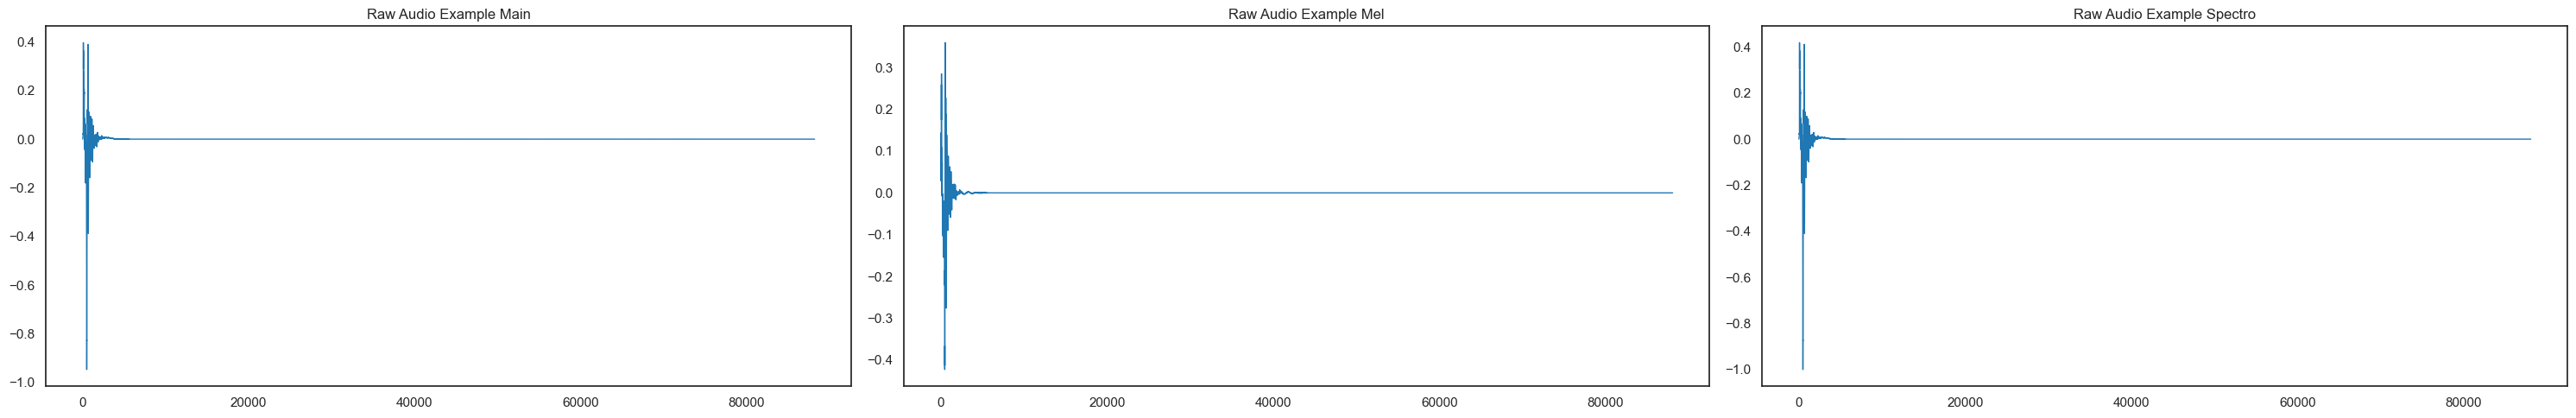

In [102]:
fig, axs = plt.subplots(1, 3, figsize=(30, 5))

pd.Series(y_main).plot(ax=axs[0],
                        lw=1,
                        title='Raw Audio Example Main',
                        color=color_pal[0])

pd.Series(y_mel).plot(ax=axs[1],
                        lw=1,
                        title='Raw Audio Example Mel',
                        color=color_pal[0])

pd.Series(y_stft).plot(ax=axs[2],
                        lw=1,
                        title='Raw Audio Example Spectro',
                        color=color_pal[0])

plt.tight_layout()
plt.show()

In [87]:
D_main = librosa.stft(y_main)
D_mel = librosa.stft(y_mel)
D_stft = librosa.stft(y_stft)

S_db_main = librosa.amplitude_to_db(np.abs(D_main), ref=np.max)
S_db_mel = librosa.amplitude_to_db(np.abs(D_mel), ref=np.max)
S_db_stft = librosa.amplitude_to_db(np.abs(D_stft), ref=np.max)

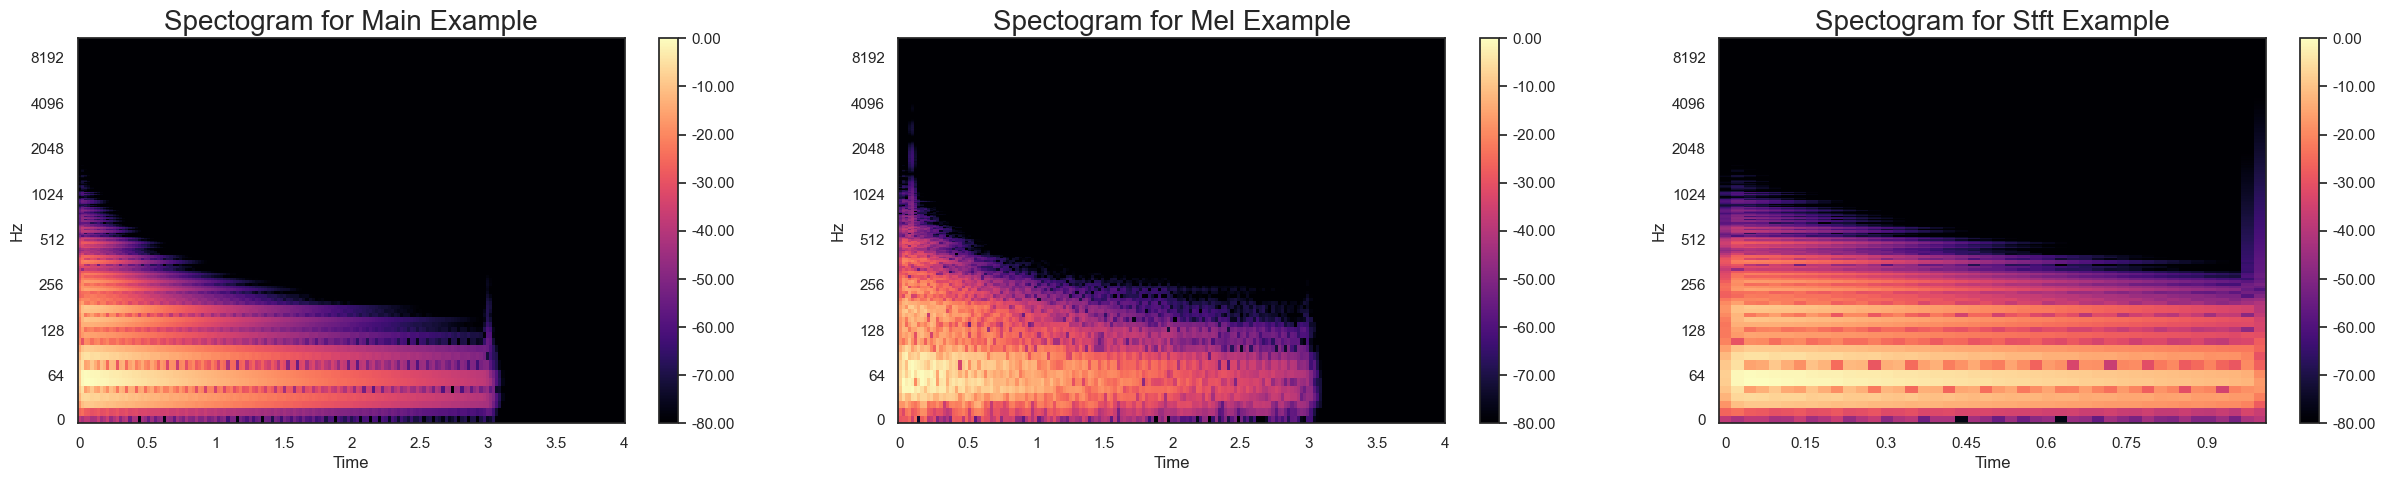

In [88]:
fig, axs = plt.subplots(1, 3, figsize=(30, 5))

img = librosa.display.specshow(S_db_main,
                              x_axis='time',
                              y_axis='log',
                              ax=axs[0])
axs[0].set_title('Spectogram for Main Example', fontsize=20)
fig.colorbar(img, ax=axs[0], format=f'%0.2f')

img = librosa.display.specshow(S_db_mel,
                              x_axis='time',
                              y_axis='log',
                              ax=axs[1])
axs[1].set_title('Spectogram for Mel Example', fontsize=20)
fig.colorbar(img, ax=axs[1], format=f'%0.2f')


img = librosa.display.specshow(S_db_stft,
                              x_axis='time',
                              y_axis='log',
                              ax=axs[2])
axs[2].set_title('Spectogram for Stft Example', fontsize=20)
fig.colorbar(img, ax=axs[2], format=f'%0.2f')


plt.show()

## GAN Model

In [143]:
import torch.nn as nn
import torch.optim as optim
import numpy as np

from torch.utils.data import DataLoader

In [145]:
base_directory = "Dataset/NSynth/audio/"

dataset = AudioSpectrogramDataset(base_directory=base_directory, spectro_type='mel-spectrogram')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

In [146]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.empty_cache()
print("Device:", device)

Device: cuda:0


In [147]:
latent_dim = 100
height = 256
width = 345

In [148]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = height // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size * (width // 4)))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, width // 4)
        img = self.conv_blocks(out)
        return img


In [154]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        
        self.adv_layer = nn.Sequential(nn.Linear(45056, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


In [155]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

adversarial_loss = torch.nn.BCELoss().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):

        real_spectrograms = data.to(device)
        real = torch.ones((real_spectrograms.size(0), 1), device=device)
        fake = torch.zeros((real_spectrograms.size(0), 1), device=device)

        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        z = torch.randn((real_spectrograms.size(0), latent_dim), device=device)

        gen_spectrograms = generator(z)
        g_loss = adversarial_loss(discriminator(gen_spectrograms), real)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(real_spectrograms), real)
        fake_loss = adversarial_loss(discriminator(gen_spectrograms.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

In [157]:
generator.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=704512, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [158]:
z = torch.randn(1, latent_dim).to(device)
generated_spectrogram = generator(z)

In [159]:
generated_spectrogram.squeeze().shape

torch.Size([256, 344])

In [160]:
spectrogram = generated_spectrogram.cpu().detach().numpy()
spectrogram = spectrogram.squeeze()

In [161]:
spectrogram.shape

(256, 344)

In [ ]:
# audio = librosa.istft(spectrogram.squeeze())
audio =  librosa.feature.inverse.mel_to_audio(spectrogram)
sf.write('Generated_samples/Magenta_genrated.wav', audio, 22050)